# Overview

Here, we load the fetal-only hits from the gchromvar analysis, and predict
the accessibility for the reference sequences (with the non-effect allele)
and the alt sequences (with the effect allele installed). We interpret
the model predictions to understand the impact of the variants on motifs
which drive accessibility.

We generally follow the scores implemented in the Kundaje Lab [varscore repo](https://github.com/kundajelab/varscore/tree/main).

Run in the `tangermeme` environment on lab cluster.

## Procedure

- Load coordinates and cell type for each variant
- Load peaks from that cell type
- Figure out which peak the variant overlaps
- Install variant in peak
- Make the predictions on that sequence w/ REF and ALT alleles
- DeepLIFT the predictions to get contribution scores

# Setup

In [2]:
%load_ext autoreload
%autoreload 2

# deal with matplotlib plots
%matplotlib inline

# display all outputs in a cell
get_ipython().ast_node_interactivity = 'all'

from IPython.display import display, HTML

In [3]:
# misc
import sys
import os
import numpy as np
import random
from tqdm import tqdm
import pandas as pd

# io
import h5py
from pyfaidx import Fasta

# ML
import bpnetlite
from bpnetlite import ChromBPNet
from bpnetlite import BPNet
from bpnetlite.bpnet import CountWrapper
from bpnetlite.attribute import deep_lift_shap

import torch

import pickle

import pyranges as pr

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn; seaborn.set_style('white')
import matplotlib.ticker as ticker
import plotnine as pn
import logomaker
import tangermeme
from tangermeme.plot import plot_logo

from tangermeme.utils import random_one_hot, _validate_input
from tangermeme.utils import characters
from tangermeme.ersatz import substitute
from tangermeme.utils import one_hot_encode

print(np.__version__)
print(tangermeme.__version__)
print(bpnetlite.__version__)
print(torch.__version__)

# os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['CUDA_VISIBLE_DEVICES']='MIG-40f43250-998e-586a-ac37-d6520e92590f'

torch.manual_seed(100)

# editable text in PDFs
# https://stackoverflow.com/a/54111532
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sys.path.append("../03-chrombpnet/")
import tangermeme_utils as tanutils
from tangermeme_utils.utils import plot_motif
from tangermeme_utils.eval import summarize_across_folds, mean_across_sequences
from tangermeme_utils.wrappers import ChromBPNetWrapper, reshape_folds

2.0.2
0.4.3
0.8.1
2.3.1+cu121


In [4]:
torch.cuda.device_count()

1

In [5]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

torch.cuda.is_available()

t1 = torch.randn(1,2).to(dev)
t1
t1.device

device(type='cuda')

True

tensor([[ 0.3607, -0.2859]], device='cuda:0')

device(type='cuda', index=0)

# Variables

In [6]:
INPUTLEN = 2114
OUTPUTLEN = 1000
SHIFT_REL_INPUT = np.int64((2114 - 1000) / 2)
SHIFT_REL_INPUT

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

LOGO_ALPHABET = 'ACGT'

# finemo colorscheme
LOGO_COLORS = {"A": '#109648', "C": '#255C99', "G": '#F7B32B', "T": '#D62839'}

# logomaker colorscheme
LOGO_COLORS2= {
        'G': [1, .65, 0],
        'T': [1, 0, 0],
        'C': [0, 0, 1],
        'A': [0, .5, 0]
    }

CHAR_IGNORE = ['QWERYUIOPSDFHJKLZXVBNM']

np.int64(557)

# Paths

In [7]:
with open("../DURGA_DIRS.txt", 'r') as f:
	proj_in = f.readline().strip()
	proj_out = f.readline().strip()

with open("../AK_PROJ_DIR.txt", 'r') as f:
    kundaje_dir = f.readline().strip()

In [8]:
genome_fa = os.path.join(kundaje_dir, "refs/hg38/chrombpnet/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

# output paths
figout = os.path.join(proj_out, "06-variants/06")

In [9]:
hg38 = Fasta(genome_fa)

# Workflow

## Load data

In [10]:
# fetal only variants
variants = pd.read_csv("06-fetal_only_SNPs_coords.tsv", sep = "\t")
variants
variants.shape

,fullTraitName,trait,rsid,snpChr.hg38,snpPos.hg38,ref,alt,ref_new,alt_new,organ,L2_celltype,selected_cluster,motifs
0,GCST90204167_D007037_Hypothyroidism,Hypothyroidism,rs10748781,chr10,99523573,C,A,C,A,Stomach,endothelial,10,447|STAT
1,GCST90038616_D001249_Asthma,Asthma,rs113892147,chr12,57610287,A,G,G,A,Lung,macrophage,12,400|NRF1
2,GCST90038616_D001249_Asthma,Asthma,rs113892147,chr12,57610287,A,G,G,A,Muscle,macrophages,15,400|NRF1
3,GCST90038616_D001249_Asthma,Asthma,rs113892147,chr12,57610287,A,G,G,A,Skin,vascular.endothelium,4,400|NRF1
4,CA448_D003324_Coronary_artery_disease,Coronary artery disease,rs116843064,chr19,8364439,G,A,G,A,Stomach,smooth.muscle,2,"507|unresolved,repressive,YY1/2-like"
5,GCST90132314_D003324_Coronary_artery_disease,Coronary artery disease,rs116843064,chr19,8364439,G,A,G,A,Stomach,smooth.muscle,2,"507|unresolved,repressive,YY1/2-like"
6,GCST90029017_D004485_Eczema,Eczema,rs12722502,chr10,6051176,T,C,C,T,Skin,vascular.endothelium,4,157|ETS:ELF/ETV#1
7,GCST90132314_D003324_Coronary_artery_disease,Coronary artery disease,rs12740374,chr1,109274968,G,T,G,T,Muscle,endothelial,6,456|ZEB/SNAI
8,GD03523_D009203_Myocardial_infarction,Myocardial infarction,rs12740374,chr1,109274968,G,T,G,T,Muscle,endothelial,6,456|ZEB/SNAI
9,AT000_D012140_J40_J47_Chronic_lower_respirator...,J40-J47 Chronic lower respiratory diseases,rs1837253,chr5,111066174,T,C,T,C,Skin,vascular.endothelium,4,432|SOX#1


(26, 13)

## Helper function

In [ ]:
# make a variant dict from one row of the dataframe
def variant_dict(row):

	variant = {
		"chr": row["snpChr.hg38"],
		"pos": int(row["snpPos.hg38"]) - 1,
		"ref": row["ref_new"],
		"alt": row["alt_new"],
		"causaldb_noneffect": row["ref"],
		"causaldb_effect": row["alt"],
		"variant_id": row["rsid"],
		"cluster": row['organ'] + "_c" + str(row['selected_cluster']),
		"trait": row["fullTraitName"],
		"motif": row["motifs"],
		"celltype": row["L2_celltype"]
	} 

	return variant

variant_dict(variants.iloc[0])

{'chr': 'chr10',
 'pos': 99523572,
 'ref': 'C',
 'alt': 'A',
 'causaldb_noneffect': 'C',
 'causaldb_effect': 'A',
 'variant_id': 'rs10748781',
 'cluster': 'Stomach_c10',
 'trait': 'GCST90204167_D007037_Hypothyroidism',
 'motif': '447|STAT',
 'celltype': 'endothelial'}

{'chr': 'chr12',
 'pos': 57610286,
 'ref': 'G',
 'alt': 'A',
 'causaldb_noneffect': 'A',
 'causaldb_effect': 'G',
 'variant_id': 'rs113892147',
 'cluster': 'Lung_c12',
 'trait': 'GCST90038616_D001249_Asthma',
 'motif': '400|NRF1',
 'celltype': 'macrophage'}

In [12]:
def score_variant(var_dict, outdir, center_variant = False):
	"""
	Score a variant using ChromBPNet.

	Parameters
	----------
	var_dict : dict
		Dictionary containing the variant information, with the following
		keys: chr, pos, ref, alt, variant_id, cluster, trait, motif, celltype.

	outdir : str
		Output directory to save the results (pkl of results and figure).

	center_variant : bool
		Whether to center the variant in the 2114 bp input sequence. If False, we
		find the peak that overlaps the variant and use the 2114 bp sequence
		centered at the peak summit. Default: False.
	"""

	print("@ scoring variant: ", var_dict['variant_id'])

	# get coords
	print("@ getting coords...")

	if center_variant:

		ref_seq = str(hg38[var_dict['chr']][var_dict['pos'] - INPUTLEN // 2 : var_dict['pos'] + INPUTLEN // 2])

		assert ref_seq[INPUTLEN // 2 : INPUTLEN // 2 + 1] == var_dict['ref']

		alt_seq = (
					ref_seq[: INPUTLEN // 2]
					+ var_dict['alt']
					+ str(
						hg38[var_dict['chr']][
							var_dict['pos'] + 1 : var_dict['pos'] + INPUTLEN // 2
						]
					)
				)
		
		var_pos_input = INPUTLEN // 2
		var_pos_output = OUTPUTLEN // 2
		key = "variantcentered"
		
	else:

		# find overlapping peak
		peaks_bed = os.path.join(proj_in, "00-inputs/chrombpnet_peaks/" + var_dict['cluster'] + "__peaks_bpnet.narrowPeak.gz")

		# read peaks
		print("@ reading peaks...")
		peaks = pd.read_csv(peaks_bed, sep = "\t", names = NARROWPEAK_SCHEMA)
		peaks.head()

		# filter peaks to those which overlap the variant
		peaks_olap = peaks[(peaks["chr"] == var_dict['chr']) & (peaks["start"] <= var_dict['pos']) & (peaks["end"] >= var_dict['pos'])]

		# choose the first if more than one
		peak_olap = peaks_olap.iloc[0]

		# get 2,114 bp ref/alt sequence around the 1,000 bp peak
		ref_seq = str(hg38[var_dict['chr']][peak_olap['start'] - SHIFT_REL_INPUT : peak_olap['end'] + SHIFT_REL_INPUT])

		# get the relative position of the variant within the peak
		var_pos_input = var_dict['pos'] - peak_olap['start'] + SHIFT_REL_INPUT
		var_pos_output = var_dict['pos'] - peak_olap['start']

		print(str(ref_seq[var_pos_input : var_pos_input + 1]))
		assert str(ref_seq[var_pos_input : var_pos_input + 1]) == var_dict['ref']

		# get the alt seq
		alt_seq = (
                ref_seq[: var_pos_input]
                + var_dict['alt']
                + ref_seq[var_pos_input + 1 :]
            )
		
		assert str(alt_seq[var_pos_input : var_pos_input + 1]) == var_dict['alt']

		key = "peakcentered"

	
	assert len(ref_seq) == INPUTLEN
	assert len(alt_seq) == INPUTLEN

	# convert to one-hot
	ref_ohe = one_hot_encode(ref_seq).type(torch.float32).unsqueeze(0)
	alt_ohe = one_hot_encode(alt_seq).type(torch.float32).unsqueeze(0)

	# load models
	print("@ loading models...")
	models = [
		ChromBPNetWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_0/models/chrombpnet_nobias.h5"))),
		ChromBPNetWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_1/models/chrombpnet_nobias.h5"))),
		ChromBPNetWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_2/models/chrombpnet_nobias.h5"))),
		ChromBPNetWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_3/models/chrombpnet_nobias.h5"))),
		ChromBPNetWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_4/models/chrombpnet_nobias.h5")))
	]

	# load model with five folds
	models_counts = [
		CountWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_0/models/chrombpnet_nobias.h5"))),
		CountWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_1/models/chrombpnet_nobias.h5"))),
		CountWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_2/models/chrombpnet_nobias.h5"))),
		CountWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_3/models/chrombpnet_nobias.h5"))),
		CountWrapper(BPNet.from_chrombpnet(filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/{var_dict['cluster']}/fold_4/models/chrombpnet_nobias.h5")))
	]

	# predict
	print("@ predicting...")
	ref_pred_list = []
	alt_pred_list = []

	for model in models:
		y_ref = tangermeme.predict.predict(model, ref_ohe)
		ref_pred_list.append(y_ref)
		y_alt = tangermeme.predict.predict(model, alt_ohe)
		alt_pred_list.append(y_alt)

	ref_pred = reshape_folds(ref_pred_list)
	alt_pred = reshape_folds(alt_pred_list)

	ref_pred_profile_mean, _ = summarize_across_folds(ref_pred[0])
	alt_pred_profile_mean, _ = summarize_across_folds(alt_pred[0])

	# compute log2FC of ALT/REF
	l2fc = ( alt_pred[1] - ref_pred[1] ) / np.log(2)
	l2fc_mean = round(l2fc.mean().item(), 3)

	# compute log2FC of REF/ALT
	l2fc_refalt = ( ref_pred[1] - alt_pred[1] ) / np.log(2)
	l2fc_refalt_mean = round(l2fc_refalt.mean().item(), 3)

	# compute a logEFC for a smaller region of 100 bp around the variant
	
	if center_variant:
		diff_local = ( alt_pred[0][:, :, :, 450:550].sum(axis = 3) - ref_pred[0][:, :, :, 450:550].sum(axis = 3) )
		diff_local_refalt = ( ref_pred[0][:, :, :, 450:550].sum(axis = 3) - alt_pred[0][:, :, :, 450:550].sum(axis = 3) )
	else:
		diff_local = ( alt_pred[0][:, :, :, (var_pos_output-50):(var_pos_output+50)].sum(axis = 3) - ref_pred[0][:, :, :, (var_pos_output-50):(var_pos_output+50)].sum(axis = 3) )
		diff_local_refalt = ( ref_pred[0][:, :, :, (var_pos_output-50):(var_pos_output+50)].sum(axis = 3) - alt_pred[0][:, :, :, (var_pos_output-50):(var_pos_output+50)].sum(axis = 3) )

	diff_local_mean = round(diff_local.mean().item(), 3)
	diff_local_mean_refalt = round(diff_local_refalt.mean().item(), 3)

	# compute attribution
	print("@ computing attribution...")
	try:

		ref_attr_list = []
		alt_attr_list = []
		
		for model in models_counts:
			y_ref = deep_lift_shap(model, ref_ohe, random_state=0)
			ref_attr_list.append(y_ref)
			y_alt = deep_lift_shap(model, alt_ohe, random_state=0)
			alt_attr_list.append(y_alt)

		ref_attr = torch.stack(ref_attr_list, dim=0)
		alt_attr = torch.stack(alt_attr_list, dim=0)
		ref_attr_mean, _ = summarize_across_folds(ref_attr)
		alt_attr_mean, _ = summarize_across_folds(alt_attr)
		
	except Exception as e:
		print(f"Error during attribution computation: {e}")
		return

	results = {
		"key": key,
		"ref_pred_profile_mean": ref_pred_profile_mean,
		"alt_pred_profile_mean": alt_pred_profile_mean,
		"l2fc_mean": l2fc_mean,
		"diff_local_mean": diff_local_mean,
		"l2fc_refalt_mean": l2fc_refalt_mean,
		"diff_local_mean_refalt": diff_local_mean_refalt,
		"ref_attr_mean": ref_attr_mean,
		"alt_attr_mean": alt_attr_mean,
		"var_pos_input": var_pos_input,
		"var_pos_output": var_pos_output
	}
	

	# dump pickle
	print("@ dumping pickle...")
	with open(os.path.join(outdir, var_dict['trait'] + "_" + var_dict['variant_id'] + "_" + var_dict['cluster'] + "_" + key + ".pkl"), "wb") as f:
		pickle.dump(results, f)

	results_tsv = pd.DataFrame({
		"trait": [var_dict['trait']],
		"organ": [var_dict['cluster']],
		"cluster": [var_dict['cluster']],
		"celltype": [var_dict['celltype']],
		"motif": [var_dict['motif']],
		"variant": [var_dict['variant_id']],
		"chr": [var_dict['chr']],
		"pos": [var_dict['pos']],
		"ref": [var_dict['ref']],
		"alt": [var_dict['alt']],
		"causaldb_noneffect": [var_dict['causaldb_noneffect']],
		"causaldb_effect": [var_dict['causaldb_effect']],
		"key": [key],
		"l2fc_mean": [l2fc_mean],
		"diff_local_mean": [diff_local_mean],
		"l2fc_refalt_mean": [l2fc_refalt_mean],
		"diff_local_mean_refalt": [diff_local_mean_refalt]
	})

	# if peak centered, at the peak coords
	if not center_variant:
		results_tsv["peak_start"] = peak_olap['start']
		results_tsv["peak_end"] = peak_olap['end']

	# write tsv
	results_tsv.to_csv(os.path.join(outdir, var_dict['trait'] + "_" + var_dict['variant_id'] + "_" + var_dict['cluster'] + "_" + key + ".tsv"), sep = "\t", index = False)

	# write to BED
	if not center_variant:

		print("@ writing to BED...")

		pred_ref = ref_pred_profile_mean.squeeze()
		pred_alt = alt_pred_profile_mean.squeeze()

		attr_ref = ref_attr_mean.sum(axis = 1).squeeze().T[(INPUTLEN // 2 - 500):(INPUTLEN // 2 + 500)]
		attr_alt = alt_attr_mean.sum(axis = 1).squeeze().T[(INPUTLEN // 2 - 500):(INPUTLEN // 2 + 500)]

		attr_ref_ohe = ref_attr_mean.squeeze().T[(INPUTLEN // 2 - 500):(INPUTLEN // 2 + 500)]
		attr_alt_ohe = alt_attr_mean.squeeze().T[(INPUTLEN // 2 - 500):(INPUTLEN // 2 + 500)]

		# convert to data frame
		pred_ref_df = pd.DataFrame(
			{
				"chr": var_dict['chr'],
				"start": np.arange(peak_olap['start'], peak_olap['end']),
				"end": np.arange(peak_olap['start'] + 1, peak_olap['end'] + 1),
				"pred_ref": pred_ref,
				"pred_alt": pred_alt,
				"contrib_sum_ref": attr_ref,
				"contrib_sum_alt": attr_alt,
				"contrib_ref_A": attr_ref_ohe[:, 0],
				"contrib_ref_C": attr_ref_ohe[:, 1],
				"contrib_ref_G": attr_ref_ohe[:, 2],
				"contrib_ref_T": attr_ref_ohe[:, 3],
				"contrib_alt_A": attr_alt_ohe[:, 0],
				"contrib_alt_C": attr_alt_ohe[:, 1],
				"contrib_alt_G": attr_alt_ohe[:, 2],
				"contrib_alt_T": attr_alt_ohe[:, 3]
			}
		)

		# write to BED
		pred_ref_df.to_csv(os.path.join(outdir,
									var_dict['trait'] + "_" + var_dict['variant_id'] + "_" + var_dict['cluster'] + "_" + key + ".bed"),
									sep = "\t", index = False, header = False)

	return results


def plot_variant(results, var_dict, outdir, ylim = None, contrib_flank = 70, show_fig = False):

	center_variant = False
	if results['key'] == "variantcentered":
		center_variant = True

	# plot
	print("@ plotting...")
	fig, ax = plt.subplots(4, 1, figsize = (11, 6))

	alpha = 0.3

	pred_ref = results['ref_pred_profile_mean'].squeeze()
	pred_alt = results['alt_pred_profile_mean'].squeeze()

	attr_ref = results['ref_attr_mean'].sum(axis = 1).squeeze().T[(INPUTLEN // 2 - 500):(INPUTLEN // 2 + 500)]
	attr_alt = results['alt_attr_mean'].sum(axis = 1).squeeze().T[(INPUTLEN // 2 - 500):(INPUTLEN // 2 + 500)]

	# prediction in 1,000 bp
	ax[0].plot(pred_ref, linewidth = 0.5, label = "REF (5-fold mean)", color = "blue")
	ax[0].plot(pred_alt, linewidth = 0.5, label = "ALT (5-fold mean)", color = "red")
	ax[0].set_ylabel("Pred. \naccessibility")
	ax[0].axvspan(results['var_pos_output'] - 20, results['var_pos_output'] + 20, alpha = alpha, color='yellow')
	ax[0].legend(fontsize = 8)

	# attribution in 1,000 bp
	ax[1].plot(attr_ref, linewidth = 0.5, label = "REF", color = "blue")
	ax[1].plot(attr_alt, linewidth = 0.5, label = "ALT", color = "red")
	ax[1].set_ylabel("Contrib. \nscores")
	ax[1].axvspan(results['var_pos_output'] - 20, results['var_pos_output'] + 20, alpha = alpha, color = 'yellow')

	tangermeme.plot.plot_logo(np.float64(results['ref_attr_mean'][0]), start = results['var_pos_input'] - contrib_flank, end = results['var_pos_input'] + contrib_flank, ax=ax[2], ylim = ylim)
	ax[2].axvspan(contrib_flank - 0.5, contrib_flank + 0.5, alpha = alpha - 0.1, color = 'blue')
	ax[2].set_ylabel("Contrib. \nREF")
	
	tangermeme.plot.plot_logo(np.float64(results['alt_attr_mean'][0]), start = results['var_pos_input'] - contrib_flank, end = results['var_pos_input'] + contrib_flank, ax=ax[3], ylim = ylim),
	ax[3].axvspan(contrib_flank - 0.5, contrib_flank + 0.5, alpha = alpha - 0.1, color = 'red')
	ax[3].set_ylabel("Contrib. \nALT")

	# put a title at the very top
	plt.suptitle(var_dict['trait'] + ": " + var_dict['variant_id'] + ": " + var_dict['ref'] + ">" + var_dict['alt'] + ", in " + var_dict["motif"] + " (" + var_dict['cluster'] + ": " + var_dict['celltype'] + ")" +
			  "\n5-fold mean log2FC total counts (ALT/REF) = " + str(results['l2fc_mean']) +
			  "\n5-fold mean diff in local counts (ALT/REF) = " + str(results['diff_local_mean']) +
			  "\n" + results['key']
			  , fontsize = 12)
	plt.xlabel("Genomic position (bp)")
	plt.tight_layout()

	if show_fig:
		
		plt.show()

	else:

		plt.savefig(os.path.join(outdir, var_dict['trait'] + "_" + var_dict['variant_id'] + "_" + var_dict['cluster'] + "_" + results['key'] + ".pdf"))

	plt.close(fig)


## rs113892147

In [16]:
var1 = variant_dict(variants[variants['rsid'] == "rs113892147"].iloc[0])
var1

{'chr': 'chr12',
 'pos': 57610286,
 'ref': 'G',
 'alt': 'A',
 'causaldb_noneffect': 'A',
 'causaldb_effect': 'G',
 'variant_id': 'rs113892147',
 'cluster': 'Lung_c12',
 'trait': 'GCST90038616_D001249_Asthma',
 'motif': '400|NRF1',
 'celltype': 'macrophage'}

In [17]:
res1 = score_variant(var1, figout, center_variant = False)

@ scoring variant:  rs113892147
@ getting coords...
@ reading peaks...
G
@ loading models...
@ predicting...
@ computing attribution...
@ dumping pickle...
@ writing to BED...


@ plotting...


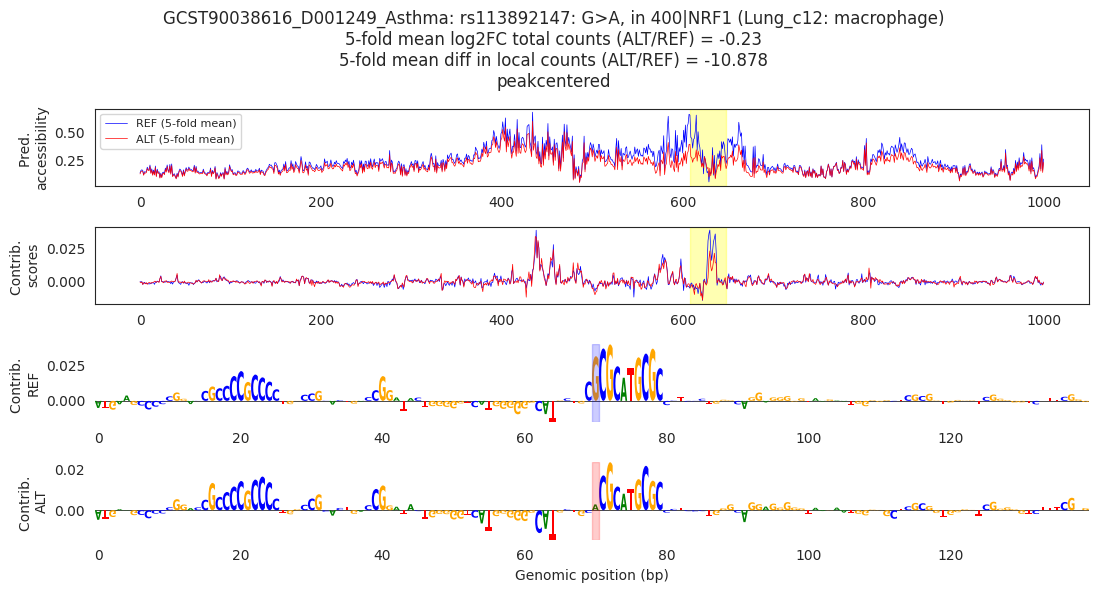

In [18]:
plot_variant(res1, var1, figout, show_fig = True)

## rs12740374

In [ ]:
var2 = variant_dict(variants[variants['rsid'] == "rs12740374"].iloc[0])
var2

{'chr': 'chr1',
 'pos': 109274967,
 'ref': 'G',
 'alt': 'T',
 'causaldb_noneffect': 'G',
 'causaldb_effect': 'T',
 'variant_id': 'rs12740374',
 'cluster': 'Muscle_c6',
 'trait': 'GCST90132314_D003324_Coronary_artery_disease',
 'motif': '456|ZEB/SNAI',
 'celltype': 'endothelial'}

In [24]:
res2 = score_variant(var2, figout, center_variant = False)

@ scoring variant:  rs12740374
@ getting coords...
@ reading peaks...
G
@ loading models...
@ predicting...
@ computing attribution...
@ dumping pickle...
@ writing to BED...


@ plotting...


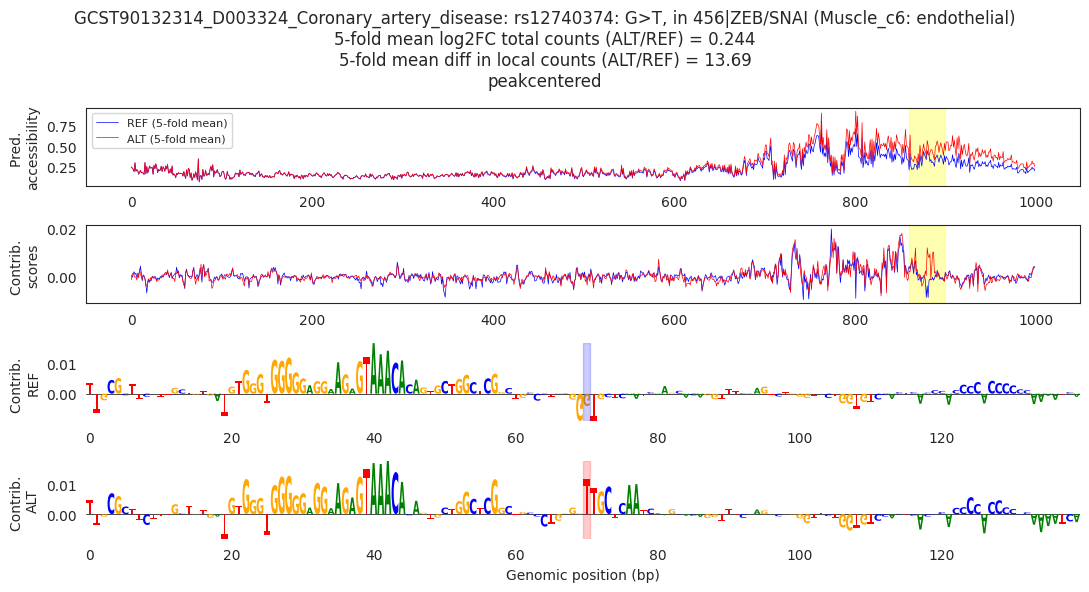

In [25]:
plot_variant(res2, var2, figout, show_fig = True)

## Score all variants

In [ ]:
for i in range(variants.shape[0]):
	var = variant_dict(variants.iloc[i])
	
	# centered on peaks
	res = score_variant(var, figout)
	plot_variant(res, var, figout, show_fig = False)


@ scoring variant:  rs10748781
@ getting coords...
@ reading peaks...
C
@ loading models...
@ predicting...
@ computing attribution...
@ dumping pickle...
@ writing to BED...
@ plotting...
@ scoring variant:  rs113892147
@ getting coords...
@ reading peaks...
G
@ loading models...
@ predicting...
@ computing attribution...
@ dumping pickle...
@ writing to BED...
@ plotting...
@ scoring variant:  rs113892147
@ getting coords...
@ reading peaks...
G
@ loading models...
@ predicting...
@ computing attribution...
@ dumping pickle...
@ writing to BED...
@ plotting...
@ scoring variant:  rs113892147
@ getting coords...
@ reading peaks...
G
@ loading models...
@ predicting...
@ computing attribution...
@ dumping pickle...
@ writing to BED...
@ plotting...
@ scoring variant:  rs116843064
@ getting coords...
@ reading peaks...
G
@ loading models...
@ predicting...
@ computing attribution...
@ dumping pickle...
@ writing to BED...
@ plotting...
@ scoring variant:  rs116843064
@ getting coords...